<a href="https://colab.research.google.com/github/windaapriliyanti/Myskill/blob/main/transformers_language_translator_eng_to_spanish_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Translator

Translating English to Spanish language using Transformer model.

* The dataset source is www.manythings.org/anki

* Evaluation using BLEU score.

### Sequence-to-sequence learning

In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Bidirectional,GRU,LSTM,Embedding
from tensorflow.keras.layers import Dense,MultiHeadAttention,LayerNormalization,Embedding,Dropout,Layer
from tensorflow.keras import Sequential,Input
from tensorflow.keras.callbacks import ModelCheckpoint

from nltk.translate.bleu_score import sentence_bleu

In [ ]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


Each line contains an English sentence and its corresponding Spanish sentence. The English sentence is the source sequence and Spanish one is the target sequence. We prepend the token "[start]" and we append the token "[end]" to the Spanish sentence.

In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

### Printing random English - Spanish text pair

In [ ]:
import random
print(random.choice(text_pairs))

("She asked me what had become of him, but I didn't know.", '[start] Ella me preguntó qué había sido de él, pero yo no lo sabía. [end]')


In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

## **Vectorizing the English and Spanish text pairs**

**Text Cleaning**

In [ ]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

**Text Standardization**
* Convert Text to lowercase

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

### Text Vectorization

We'll use two instances of the TextVectorization layer to vectorize the text data (one for English and one for Spanish), that is to say, to turn the original strings into integer sequences where each integer represents the index of a word in a vocabulary.

The English layer will use the default string standardization (strip punctuation characters) and splitting scheme (split on whitespace), while the Spanish layer will use a custom standardization, where we add the character "¿" to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend stripping the punctuation characters in either language. Instead, I would recommend turning each punctuation character into its own token, which you could achieve by providing a custom split function to the TextVectorization layer.

In [ ]:
vocab_size = 15000
sequence_length = 20

source_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

2022-10-26 14:53:38.016069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 14:53:38.113145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 14:53:38.114022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 14:53:38.115634: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**Preparing datasets for the translation task**

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
train_ds

<CacheDataset shapes: ({english: (None, 20), spanish: (None, 20)}, (None, 20)), types: ({english: tf.int64, spanish: tf.int64}, tf.int64)>

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"english {inputs['english']},\n\n\n inputs['english'].shape: {inputs['english'].shape}")
    print(f"spanish {inputs['spanish']},\n\n\n inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets {targets}, \n\n\n targets.shape: {targets.shape}")

english [[  18  116    8 ...    0    0    0]
 [   5  792    0 ...    0    0    0]
 [  79  645    0 ...    0    0    0]
 ...
 [   6 1106  334 ...    0    0    0]
 [ 533    3  574 ...    0    0    0]
 [   9  602   17 ...    0    0    0]],


 inputs['english'].shape: (64, 20)
spanish [[    2    41   106 ...     0     0     0]
 [    2   126  1932 ...     0     0     0]
 [    2    88 12108 ...     0     0     0]
 ...
 [    2     8  1625 ...     0     0     0]
 [    2     6   190 ...     0     0     0]
 [    2    19    14 ...     0     0     0]],


 inputs['spanish'].shape: (64, 20)
targets [[   41   106    21 ...     0     0     0]
 [  126  1932     3 ...     0     0     0]
 [   88 12108     3 ...     0     0     0]
 ...
 [    8  1625    18 ...     0     0     0]
 [    6   190    14 ...     0     0     0]
 [   19    14  1523 ...     0     0     0]], 


 targets.shape: (64, 20)


2022-10-26 14:53:53.374069: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Sequence-to-sequence learning with Transformer

### A Transformer for machine translation

## Transformer Encoder

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = Sequential(
            [Dense(dense_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )

        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

#### The Transformer decoder

In [ ]:
class TransformerDecoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [Dense(dense_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.layernorm_3 = LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### **Positional Embedding layer**

In [ ]:
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = Embedding(
            input_dim=input_dim, output_dim=output_dim)
        print(input_dim,output_dim)
        #intermediate = self.getPositionEncoding(seq_len=input_dim,d=vocab_size,n=output_dim)
        self.position_embeddings = Embedding(input_dim=input_dim, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def getPositionEncoding(self,seq_len, d, n = sequence_length):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        tensor = tf.convert_to_tensor(P)
        print(tensor.shape)
        return tensor

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = Dropout(0.5)(x)
decoder_outputs = Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

15000 256
15000 256


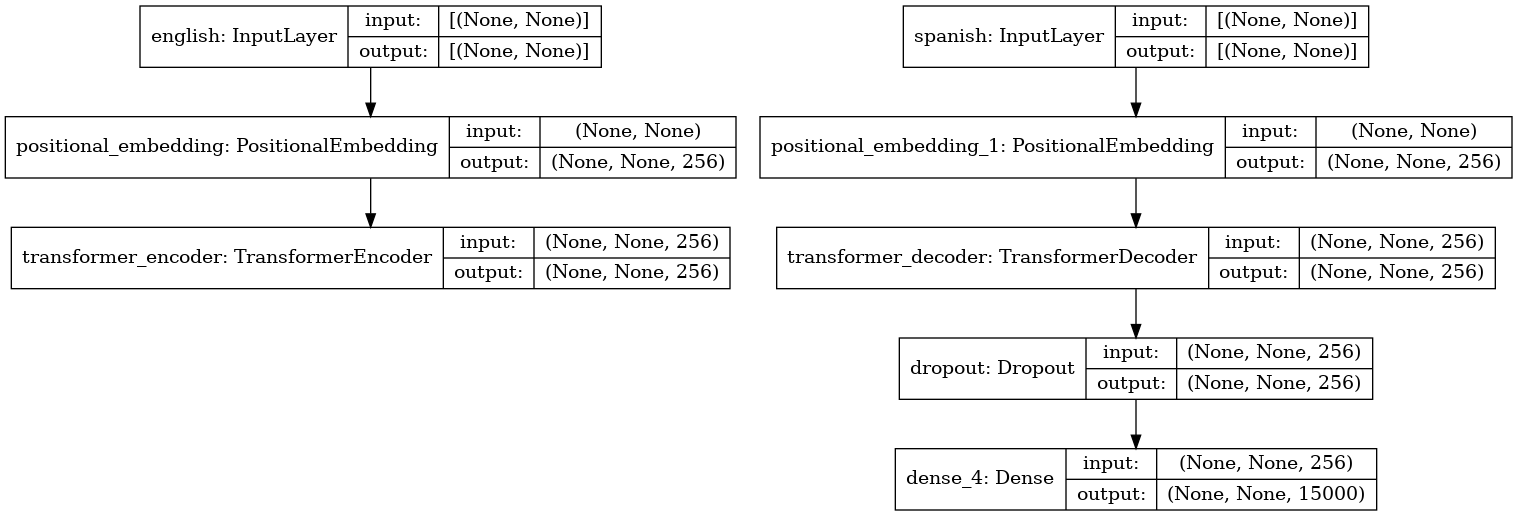

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(transformer, to_file='transformer.png', show_shapes=True)
from IPython.display import Image
Image("transformer.png")

**Training the sequence-to-sequence Transformer**

In [ ]:
EPOCHS = 30

In [ ]:
checkpoint = ModelCheckpoint(filepath='language_translation_checkpoint.hdf5',
                             save_weights_only=True,verbose=1,monitor='val_accuracy')

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=EPOCHS,callbacks=[checkpoint], validation_data=val_ds)

Epoch 1/30
   1/1302 [..............................] - ETA: 2:03:01 - loss: 3.9363 - accuracy: 0.0000e+00

2022-10-26 14:54:01.148016: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1302/1302 [==============================] - 96s 70ms/step - loss: 1.6540 - accuracy: 0.4254 - val_loss: 1.3290 - val_accuracy: 0.5168

Epoch 00001: saving model to language_translation_checkpoint.hdf5
Epoch 2/30
1302/1302 [==============================] - 90s 69ms/step - loss: 1.3220 - accuracy: 0.5386 - val_loss: 1.1603 - val_accuracy: 0.5733

Epoch 00002: saving model to language_translation_checkpoint.hdf5
Epoch 3/30
1302/1302 [==============================] - 90s 69ms/step - loss: 1.1693 - accuracy: 0.5875 - val_loss: 1.0788 - val_accuracy: 0.6030

Epoch 00003: saving model to language_translation_checkpoint.hdf5
Epoch 4/30
1302/1302 [==============================] - 90s 69ms/step - loss: 1.0830 - accuracy: 0.6193 - val_loss: 1.0347 - val_accuracy: 0.6271

Epoch 00004: saving model to language_translation_checkpoint.hdf5
Epoch 5/30
1302/1302 [==============================] - 100s 77ms/step - loss: 1.0374 - accuracy: 0.6403 - val_loss: 1.0186 - val_accuracy: 0.6343

Epoch 00005

In [ ]:
# saving model achitecture in json file
model_json = transformer.to_json()
with open("translator.json", "w") as json_file:
    json_file.write(model_json)

**Translating new sentences with our Transformer model**

In [ ]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

### Output Testing and Decoding the output sequence

In [ ]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

### Transformer translating output

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
I thought about writing you a message, but never got around to it.
[start] pensé haberte escrito un mensaje pero no se lo [UNK] [end]
-
Our school begins at eight.
[start] nuestra escuela que las dos [end]
-
Pets can be very expensive.
[start] los [UNK] se puede ser muy caro [end]
-
Tom is glad the school year is finally over.
[start] tom se preguntó mucho el colegio tiene al fin de lo que el [UNK] [end]
-
I've been to Australia once.
[start] he estado en australia una vez [end]


# Evaluation using the BLEU score

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_spa_texts = [pair[1] for pair in test_pairs]
score = 0
bleu  = 0
for i in range(20):
    candidate = decode_sequence(test_eng_texts[i])
    reference = test_spa_texts[i].lower()
    print(candidate,reference)
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu+=score
    print(f"Score:{score}")
print(f"\nBLEU score : {round(bleu,2)}/20")


[start] vas a pagar a china a china es pagar china [end] [start] ¿visitará china este otoño? [end]
Score:0.25
[start] necesito la plata de tom [end] [start] necesito la firma de tom. [end]
Score:0.39473684210526316


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

[start] Él no es posible entender [end] [start] él no puede comprenderlo. [end]
Score:0.3333333333333333
[start] las por muchas buen flores [end] [start] las rosas son mis flores favoritas. [end]
Score:0.3499999999999999
[start] tom le [UNK] de mary la revista [end] [start] tom recortó la fotografía de mary de la revista. [end]
Score:0.35555555555555557
[start] el juego empezó a las dos y media [end] [start] el juego empieza a las dos y media. [end]
Score:0.425531914893617
[start] espere un minuto [end] [start] espera un minuto. [end]
Score:0.5
[start] es una pena que no puedes viajar con nosotros [end] [start] es una lástima que no puedas viajar con nosotros. [end]
Score:0.3050847457627119
[start] mary es una mujer casado [end] [start] maría es una mujer casada. [end]
Score:0.3684210526315789
[start] el río que [UNK] ha [UNK] mis cosas se sabe [end] [start] el río que atraviesa parís es el sena. [end]
Score:0.2807017543859649
[start] me [UNK] un vaso de leche [end] [start] ¿me das un 

## Summary

* Transformer model is implemented for translating English to Spanish.
* BLEU score is the metrics used to evaluate the performance of the tranformer in translating the language.